
# Week 2 — Baseline Prediction Models & Evaluation

In this notebook, you will build **baseline prediction models** for financial
returns and evaluate them using **strictly forward-looking (time-series)
validation**.

This week focuses on **evaluation discipline**, not on maximizing performance.


## 1. Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

plt.style.use("seaborn-v0_8")


## 2. Load data from Week 1

- Reuse the data you created in Week 1.
- You can use one stock of your choice (you can repeat it for multiple stocks if you want and plot them separately)
- Take a long term horizon data set (5-10 years)


In [5]:
# Load prices and returns from Week 1 (reuse yfinance for the same horizon)
ASSET = "AAPL"
START, END = "2015-01-01", "2024-01-01"

downloaded = yf.download(ASSET, start=START, end=END, progress=False, auto_adjust=False)
if isinstance(downloaded.columns, pd.MultiIndex):
    price_series = downloaded["Adj Close"].iloc[:, 0]
else:
    price_series = downloaded["Adj Close"] if "Adj Close" in downloaded.columns else downloaded.squeeze()

price = price_series.rename("price")
df_raw = price.to_frame()

# Daily log returns (r_t)
df_raw["r_t"] = np.log(df_raw["price"] / df_raw["price"].shift(1))

# Drop first NA row
df_raw = df_raw.dropna()
print(f"Loaded {ASSET} prices: {df_raw.shape[0]} rows from {df_raw.index.min().date()} to {df_raw.index.max().date()}")
display(df_raw.tail())

Loaded AAPL prices: 2263 rows from 2015-01-05 to 2023-12-29


,price,r_t
Date,,
2023-12-22,191.788757,-0.005563
2023-12-26,191.243912,-0.002845
2023-12-27,191.342972,0.000518
2023-12-28,191.768951,0.002224
2023-12-29,190.728760,-0.005439



## 3. Feature construction

Required features:
- $r_t$
- $r_{t-1}$
- 20-day rolling mean
- 20-day rolling volatility
- 5-day momentum


In [7]:
# Construct features using only past data (predict next-day return)
feat_df = df_raw.copy()

# Target: next-day log return (forward-looking)
feat_df["target"] = feat_df["r_t"].shift(-1)

# Lagged returns
feat_df["r_t_minus1"] = feat_df["r_t"].shift(1)

# Rolling stats (use shift to avoid peeking at current target day)
feat_df["roll_mean_20"] = feat_df["r_t"].rolling(window=20, min_periods=20).mean().shift(1)
feat_df["roll_vol_20"] = feat_df["r_t"].rolling(window=20, min_periods=20).std().shift(1)

# 5-day momentum (price-based, uses only past prices)
feat_df["mom_5d"] = feat_df["price"] / feat_df["price"].shift(5) - 1

model_cols = ["r_t", "r_t_minus1", "roll_mean_20", "roll_vol_20", "mom_5d"]
data = feat_df.dropna().copy()
X = data[model_cols]
y = data["target"]
print(f"Feature-ready rows: {len(data)}; X shape={X.shape}, y shape={y.shape}")
display(data[model_cols + ["target"]].head())

Feature-ready rows: 2242; X shape=(2242, 5), y shape=(2242,)


,r_t,r_t_minus1,roll_mean_20,roll_vol_20,mom_5d,target
Date,,,,,,
2015-02-03,0.000168,0.012469,0.004082,0.023655,0.087135,0.007641
2015-02-04,0.007641,0.000168,0.005519,0.022407,0.036857,0.007112
2015-02-05,0.007112,0.007641,0.005896,0.022374,0.012728,-0.008457
2015-02-06,-0.008457,0.007112,0.005556,0.022298,0.019114,0.006621
2015-02-09,0.006621,-0.008457,0.003248,0.021155,0.013171,0.019029



## 4. Naive baselines


In [ ]:
# Naive baseline 1: zero predictor (always predicts 0 return)
def predict_zero(index):
    return pd.Series(0.0, index=index, name="zero")

In [9]:
# Naive baseline 2: rolling mean predictor (use last 20 returns from train fold)
def predict_rolling_mean(y_train, test_index, window=20):
    mean_val = y_train.iloc[-window:].mean()
    if np.isnan(mean_val):
        mean_val = 0.0
    return pd.Series(mean_val, index=test_index, name="roll_mean")


## 5. Linear models (OLS & Ridge)
Suggested that you review basic linear regression theory as well (resources given in README).

In [10]:
# Linear models: OLS and Ridge
ols = LinearRegression()
ridge = Ridge(alpha=0.5, random_state=42)


## 6. Tree-based model (Random Forest) (optional)


In [11]:
# Tree-based model (optional): Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=30,
    random_state=42,
    n_jobs=-1
)

## 7. Walk-forward evaluation

- Scikit reference for [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [12]:
# Walk-forward evaluation with TimeSeriesSplit
n_splits = 5
min_test_size = 252  # ~1 trading year for test folds

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=min_test_size)

models = {
    "zero": "baseline",  # handled separately
    "roll_mean": "baseline",  # handled separately
    "ols": ols,
    "ridge": ridge,
    "rf": rf,
}

all_preds = {}
all_truth = None
fold_rmses = {name: [] for name in models}

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Baseline 1: zero
    y_pred_zero = predict_zero(y_test.index)
    all_preds.setdefault("zero", []).append(y_pred_zero)
    fold_rmses["zero"].append(np.sqrt(mean_squared_error(y_test, y_pred_zero)))

    # Baseline 2: rolling mean of train returns
    y_pred_roll = predict_rolling_mean(y_train, y_test.index, window=20)
    all_preds.setdefault("roll_mean", []).append(y_pred_roll)
    fold_rmses["roll_mean"].append(np.sqrt(mean_squared_error(y_test, y_pred_roll)))

    # OLS
    ols.fit(X_train, y_train)
    y_pred_ols = pd.Series(ols.predict(X_test), index=y_test.index, name="ols")
    all_preds.setdefault("ols", []).append(y_pred_ols)
    fold_rmses["ols"].append(np.sqrt(mean_squared_error(y_test, y_pred_ols)))

    # Ridge
    ridge.fit(X_train, y_train)
    y_pred_ridge = pd.Series(ridge.predict(X_test), index=y_test.index, name="ridge")
    all_preds.setdefault("ridge", []).append(y_pred_ridge)
    fold_rmses["ridge"].append(np.sqrt(mean_squared_error(y_test, y_pred_ridge)))

    # Random Forest
    rf.fit(X_train, y_train)
    y_pred_rf = pd.Series(rf.predict(X_test), index=y_test.index, name="rf")
    all_preds.setdefault("rf", []).append(y_pred_rf)
    fold_rmses["rf"].append(np.sqrt(mean_squared_error(y_test, y_pred_rf)))

    # Store truth (same order) once
    if all_truth is None:
        all_truth = y_test
    else:
        all_truth = pd.concat([all_truth, y_test])

# Concatenate predictions across folds
for name in all_preds:
    all_preds[name] = pd.concat(all_preds[name]).sort_index()

print("Fold RMSEs:")
for name, scores in fold_rmses.items():
    print(f"  {name:9s}: {np.mean(scores):.6f} ± {np.std(scores):.6f}")

Fold RMSEs:
  zero     : 0.019462 ± 0.005865
  roll_mean: 0.020628 ± 0.005203
  ols      : 0.019545 ± 0.005913
  ridge    : 0.019466 ± 0.005906
  rf       : 0.019413 ± 0.005830



## 8. Prediction accuracy


In [13]:
# Compute RMSE for all models and compare them
rmse_table = {}
for name, preds in all_preds.items():
    rmse_table[name] = np.sqrt(mean_squared_error(all_truth, preds))

rmse_df = pd.Series(rmse_table).sort_values()
print("Overall RMSE (lower is better):")
display(rmse_df.to_frame("RMSE"))

Overall RMSE (lower is better):


,RMSE
rf,0.020270
zero,0.020326
ridge,0.020342
ols,0.020420
roll_mean,0.021274


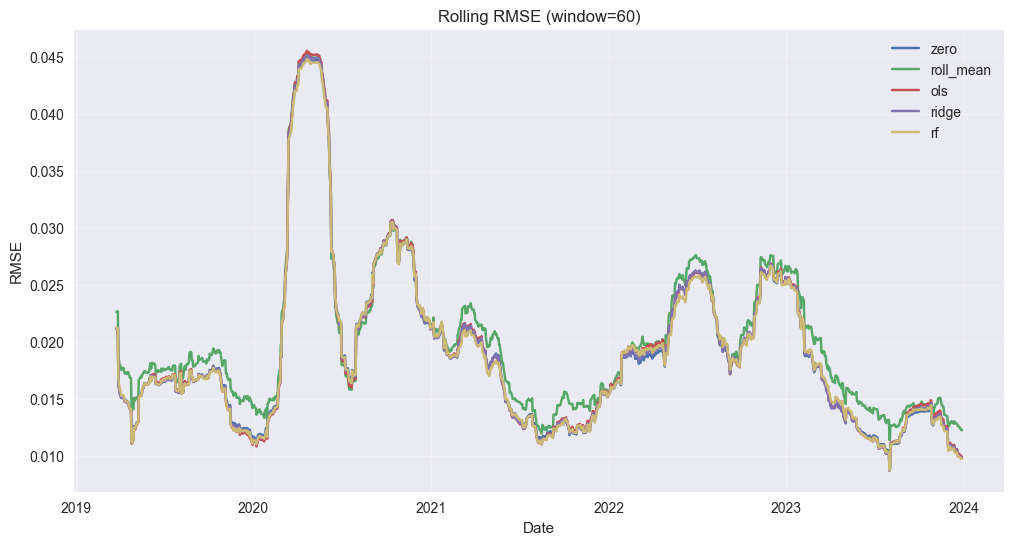

In [ ]:
# Plot rolling RMSE vs time for all models

def rolling_rmse(y_true, y_pred, window=60):
    return (y_true - y_pred).pow(2).rolling(window=window, min_periods=window).mean().apply(np.sqrt)

roll_window = 60
roll_curves = {}
for name, preds in all_preds.items():
    aligned_true = all_truth.loc[preds.index]
    roll_curves[name] = rolling_rmse(aligned_true, preds, window=roll_window)

plt.figure(figsize=(12, 6))
for name, series in roll_curves.items():
    plt.plot(series.index, series, label=name)
plt.title(f"Rolling RMSE (window={roll_window})")
plt.ylabel("RMSE")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Bonus: volatility-normalized prediction error
vol_series = data.loc[all_truth.index, "roll_vol_20"].replace(0, np.nan)

norm_stats = {}
for name, preds in all_preds.items():
    aligned_true = all_truth.loc[preds.index]
    vol = vol_series.loc[preds.index]
    norm_err = np.sqrt(((aligned_true - preds) ** 2) / (vol ** 2))
    norm_err = norm_err.replace([np.inf, -np.inf], np.nan).dropna()
    norm_stats[name] = {
        "mean_norm_err": norm_err.mean(),
        "median_norm_err": norm_err.median(),
    }

norm_df = pd.DataFrame(norm_stats).T
print("Volatility-normalized error (lower is better):")
display(norm_df)
##

Volatility-normalized error (lower is better):


,mean_norm_err,median_norm_err
zero,0.817935,0.629172
roll_mean,0.896634,0.706777
ols,0.820189,0.642409
ridge,0.817002,0.630361
rf,0.819490,0.631155


## 9. Bonus: Looking at a toy strategy based on predictions
Define a simple "all-in" strategy where you go all long (+1) when you predict the stock to be going up, and all short (-1) when you predict the stock to be going down
$$
\text{position}_t = \text{sign}(y_\text{pred})
$$
Then, your returns for the $t$-th day (assuming daily returns) will be $(\text{position}_t \times y_\text{true})$ (note $y_\text{true} = r_t$).

Note that this is extremely simplistic and ignore any predictions related magnitude of expected returns, or expected volatility data etc. It is used only as a demonstration of what a prediction-based strategy may look like.

**Plot your returns using this strategy based on all the models above and compare them!**

In [16]:
# Compute positions and daily returns for each model
strategy_returns = {}
for name, preds in all_preds.items():
    aligned_true = all_truth.loc[preds.index]
    positions = np.sign(preds)
    returns = positions * aligned_true
    strategy_returns[name] = returns

print({name: f"mean daily return={rets.mean():.6f}" for name, rets in strategy_returns.items()})

{'zero': 'mean daily return=0.000000', 'roll_mean': 'mean daily return=-0.000388', 'ols': 'mean daily return=0.000783', 'ridge': 'mean daily return=0.001240', 'rf': 'mean daily return=0.000987'}


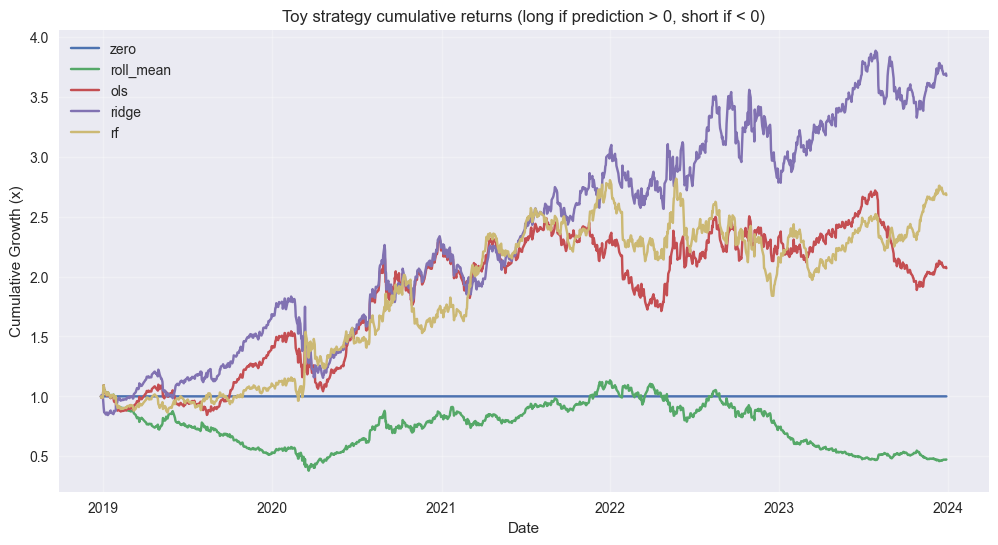

In [17]:
# Plot strategy cumulative returns
plt.figure(figsize=(12, 6))
for name, rets in strategy_returns.items():
    equity = (1 + rets).cumprod()
    plt.plot(equity.index, equity, label=name)
plt.title("Toy strategy cumulative returns (long if prediction > 0, short if < 0)")
plt.ylabel("Cumulative Growth (x)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 10. Discussion questions

1. Why do we need naive baselines?
2. How does the evaluation strategy here (walk-forward evaluation) differ from the random training-test dataset splits used in convention ML?
3. *(Addon)* And, why does random splitting technique fail here?
4. Interpret the RMSE values and rolling RMSE plot results very briefly.
5. *(Addon)* Are there periods where model performance degrades noticeably? What might this indicate?
6. Why might Random Forest overfit?
7. *(Bonus)* Two models have similar RMSE, but one makes larger errors primarily during high-volatility periods. Why might this model be *less dangerous* in a portfolio context?